In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.01
m1 = 0.
s0 = 0.5
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)

In [3]:
params.shape

(32, 3, 4)

In [4]:
def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X) + param[:,-1]
    return X

In [5]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype(floatX)

In [6]:
xs

array([[[ 0.19346423, -0.49674494,  1.03272322],
        [ 0.75089704, -0.24004044,  1.56023568],
        [ 1.32750344, -0.11221079,  1.71005292],
        [ 1.52194586, -0.21827614,  1.65352565],
        [ 1.59104575, -0.36965128,  1.71710531],
        [ 1.94791322, -0.38744022,  1.88844369],
        [ 2.00793466, -0.50160722,  2.08154117],
        [ 2.16763723, -0.23440914,  2.53786771],
        [ 2.5673579 , -0.02512258,  2.26939423],
        [ 2.32300895, -0.17351812,  1.89459183],
        [ 1.91274935, -0.4183005 ,  1.98138751],
        [ 2.11211229, -0.54368057,  2.17311137],
        [ 2.2869644 , -0.4955708 ,  2.58477752],
        [ 2.76532993, -0.36920278,  2.7437916 ],
        [ 2.88744677, -0.40642631,  2.69340905],
        [ 2.91296897, -0.61181592,  2.76246208],
        [ 3.15824728, -0.70285377,  2.91540517],
        [ 3.39448326, -0.72092846,  3.2602625 ],
        [ 3.75839297, -0.59519568,  3.5311124 ],
        [ 3.91858443, -0.51728211,  3.68425203],
        [ 3.97623264

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=None):
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([ResFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(4)], init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1], init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 32, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
#outputs = tf.cast(outputs, tf.float64)

In [13]:
prior

<tf.Tensor 'add_33:0' shape=() dtype=float64>

In [14]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred)
    return ll

In [15]:
logl = create_loglik()

In [16]:
xs.shape

(1, 32, 3)

In [17]:
logl

<tf.Tensor 'add_126:0' shape=() dtype=float64>

In [18]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [19]:
ent

<tf.Tensor 'Sum_33:0' shape=() dtype=float64>

In [20]:
loss = -logl - prior + ent
loss /= n*dim[0]*dim[1]

In [21]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()

In [23]:
tf.global_variables_initializer().run()

In [24]:
prior.eval(), ent.eval(), logl.eval()

(869.6709343350302, 1627.4248843349023, -154913.24732602533)

In [25]:
loss.eval()

622.6644038429033

In [45]:
for _ in range(500):
    for _ in range(200):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)

9.617019380381883
7.957151190116934
11.453441925682503
9.461459369196353
9.284540473440012
6.871216553627151
7.127322788288763
7.13288213545372
8.49180196354145
6.14686145763336
8.287670531395213
7.500339389566393
6.94914893153094
7.879517153713572
9.209678994049517
8.70732062700039
8.959132093528154
7.095996865782825
8.04309717801275
7.302153255891287
6.408186005427873
7.802891595138223
7.342779298244456
8.15859663378692
7.063807408375086
6.008644228020079
9.59801243915157
6.677829012878007
8.976710986217837
8.129521947647502
7.944670471332571
7.9620420074089475
6.805880667385186
8.039239663265024
6.3301889860278635
7.597241472149203
7.932262518801628
8.176288762318002
6.502400097627304
7.4556449279540615
6.757014345921299
6.404180623773574
7.662706107142998
7.4397939015557135
6.868078071720554
7.5444376218969715
7.441699633599939
6.334399672776745
5.847251456222099
6.467963012423701
6.532186272701629
6.561276594117643
6.084097919320379
7.332999853445979
6.148643694752117
6.3818630255

KeyboardInterrupt: 

In [28]:
out = tf.reshape(outputs, [n, 3, 4])

In [46]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [47]:
samples.shape

(1000, 32, 3, 4)

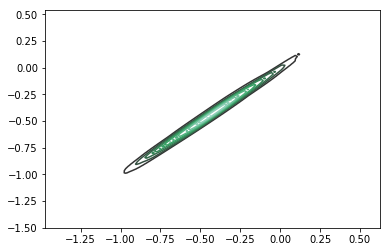

In [48]:
sns.kdeplot(samples[:,18,1,1], samples[:,28,1,1])
plt.show()

In [49]:
params[18,1,1]

0.49052327919455724

In [50]:
np.mean(samples[:,18,1,1], axis=0)

-0.4392966309991941

In [51]:
params[0] - params[-1]

array([[-0.03363443,  0.01594778, -0.05966114, -0.03184394],
       [ 0.01225283, -0.06333269,  0.01810212,  0.05804125],
       [-0.0916567 ,  0.03942744, -0.0750497 , -0.04911167]])